In [4]:
import os;
import re;
import copy;
import numpy as np;
import matplotlib.pyplot as plt;
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"#选择哪一块gpu,-1代表cpu

In [5]:
# 载入文档
def load_documents(path):
    files =[];
    for filename in os.listdir(path):
        path_of_file = path + '/' + filename;
        if os.path.getsize(path_of_file) > 0:
            if len(filename) > 3 and filename[-3:] == 'txt':
                f = open(path_of_file,'r');
                content = f.read();
                files.append(content);
                f.close();
            else:
                print('file <\'' + filename + '\'> was ignored for <txt> file only');
        else:
            print('file <\'' + filename + '\'> was ignored for its zero size');
    print('done, while Getting {} documents loaded'.format(len(files)))
    return files;

In [6]:
def tokenize(document,clear_list,rm_words=[],reverse=True):
    # 将文档合并为一个词序列
    words_sequence = [];
    words_sequence_doc = [];
    for text in document:
        text = re.sub(clear_list,' ',text);# 替换指定符号为空格
        text = re.sub("( )+"," ",text); # 将连续多个空格替换成一个
        words_list = text.split(' ');
        words_sequence += words_list;
        words_sequence_doc.append(words_list);
    # 去掉不需要的单词
    selected_sequency = [];
    for w in words_sequence:
        if not ((w == '') or (w in rm_words)):
            selected_sequency.append(w);
    selected_sequency_doc = [];
    for text in words_sequence_doc:
        tmp = [];
        for w in text:
            if not ((w == '') or (w in rm_words)):
                tmp.append(w);
        selected_sequency_doc.append(tmp);
    # 从词序列中统计词频
    N = len(selected_sequency);
    voc = {};   # 单词表
    for word in selected_sequency:
        if not word in voc.keys():
            voc.update({word:1});
        else:
            voc[word]+=1
    # 将单词按词频排序
    words = list(voc.keys());
    frequency = list(voc.values());
    # 按照frequency排序，获得排序后frequency和原下标
    sorted_nums = sorted(enumerate(frequency), key=lambda x: x[1]);
    idx = [j[0] for j in sorted_nums];
    nums = [j[1] for j in sorted_nums];
    # 按照下标解出对应单词
    sorted_words = [];
    for i in idx:
        sorted_words.append(words[i]);
    if reverse == True:
        sorted_words.reverse();
        nums.reverse();
    sorted_voc = dict(zip(sorted_words,nums));
    return sorted_voc,selected_sequency,selected_sequency_doc;

In [7]:
# 将单词转化为编号
def words2idx(words_sequency_doc,voc_list):
    w2i = {voc_list[i]:i for i in range(len(voc_list))};
    idx = [];
    for text in words_sequency_doc:
        tmp = [];
        for w in text:
            if w in voc_list:
                index = w2i[w];
                tmp.append(index);
        idx.append(tmp);
    return idx;

In [8]:
def estimate(epoch_n,package,print_info=False,simple_return=True):
    M,N,K,V,z,p,theta,phi,idx,alpha,beta,nd,nd_s,nw,nw_s = package;
    history =[];
    for e in range(epoch_n):
        last_theta = copy.deepcopy(theta);
        last_phi = copy.deepcopy(phi);
        for i in range(M):# 遍历文档
            for j in range(N[i]):# 遍历该文档单词
                # 单个单词迭代
                topic_index = z[i][j];# 提取该单词的主题
                words_index = idx[i][j];# 单词下标
                # 获取排除该单词的分布
                nw[words_index,topic_index] -= 1;
                nw_s[topic_index] -= 1;
                nd[i,topic_index] -= 1;
                nd_s[i] -= 1;
                # 采样
                # 初始化该单词所属主题的分布
                for k in range(K):
                    p[k] = ((nw[words_index][k]+beta[words_index])/(nw_s[k] + np.sum(beta))) * (nd[i][k]+alpha[k]);
                # 选取最大者
                topic_index = np.argmax(p);
                # print(topic_index,end=' ')
                nw[words_index,topic_index] += 1;
                nw_s[topic_index] += 1;
                nd[i,topic_index] += 1;
                nd_s[i] += 1;
                z[i][j] = topic_index;# 重置单词的主题
        # 计数phi和theta
        for i in range(M):
            for k in range(K):
                theta[i,k] = (nd[i,k]+alpha[k])/(nd_s[i]+np.sum(alpha));
        for k in range(K):
            for j in range(V):
                phi[k,j] = (nw[j,k]+beta[j])/(nw_s[k]+np.sum(beta));
        delta = [
            np.max(np.abs(last_theta - theta)),
            np.max(np.abs(last_phi - phi))
        ];
        history.append(delta);
        if print_info:
            print('epoch {}/{}, delta: theta:{:.4f}, phi:{:.4f}'.format(e+1,epoch_n,delta[0],delta[1]),end='\n');
    package = [history,M,N,K,V,z,p,theta,phi,idx,alpha,beta,nd,nd_s,nw,nw_s];
    if simple_return:
        return history;
    else:
        return copy.deepcopy(package);

In [9]:
def show_delta(history):
    data = np.array(history);
    plt.plot(data);
    plt.ylabel('Delta');
    plt.xlabel('epoch');
    plt.legend(['Theta','Phi']);

In [10]:
def init_param(K,package):
    words,document,idx = package;
    alpha = [1/K]*K;# K，p(zk|dm) 所服从分布 Dir(alpha) 的超参数
    beta = [0.01]*len(words);# V，p(wj|zk) 所服从分布 Dir(beta) 的超参数
    # 参数
    V = len(words);# 词典内容数量
    M = len(document);# 文档数
    N = np.zeros(M,dtype=np.int32);# 各文档词数
    for i in range(len(idx)):
        N[i] = len(idx[i]);
    # 分布参数
    p = np.zeros(K); # K采样时所需要的分布
    theta = np.zeros((M,K));# 文档-主题分布
    phi = np.zeros((K,V));# 主题-词项分布
    # 主题参数
    z = [];# 单词的主题 M*N_m
    # initiate
    for i in range(len(idx)):
        z.append(np.zeros(len(idx[i]),dtype=np.int32));
    # 计数参数
    nw = np.zeros((V,K)); # V*K，词j与主题k上的共现频数
    nd = np.zeros((M,K));# M*K，文章i属于主题k的词的频数
    nw_s = np.zeros(K); # K， 属于主题k的词的频数
    nd_s = np.zeros(M); # M，文章i的词频
    for i in range(M):
        nd_s[i] = N[i];
        for j in range(N[i]):
            topic_index = np.random.randint(0,K);
            words_index = idx[i][j];
            z[i][j] = topic_index;
            nw[words_index][topic_index] += 1;
            nd[i][topic_index] += 1;
            nw_s[topic_index] += 1;
    package = [V,M,N,p,z,theta,phi,nw,nd,nw_s,nd_s];
    return copy.deepcopy(package);

In [11]:
# 文档目录，注意修改。
path = r'document';
document = load_documents(path);
# '''2个名为 <No*> 的文件为验证上述函数泛化能力的空文件'''

# 载入停顿词
path = r'stop_words/stop words.txt';
f = open(path,'r',);
stop_words = f.read();
f.close();
stop_words = stop_words.split('\n');

# 载入实体
stop_words += ['The','sam','michelle','lele'];

# tokenize
clear_list = '[(),.”“\":;\n!?]'# 指定需要替换的符号
voc,words_sequency,words_sequency_doc = tokenize(document,clear_list,rm_words=stop_words);
voc_list = list(voc.keys());

# words2idx
max_words = -1;
idx = words2idx(words_sequency_doc,voc_list[:max_words]);# 两者结果相同
# max_words: 考虑的词表中单词的数量，-1表示全部
# idx_list_resw = words2idx(words_list_rmsw,words); 

file <'Nothing.txt'> was ignored for its zero size
file <'NO'> was ignored for <txt> file only
done, while Getting 8 documents loaded


In [12]:
# 超参数
K = 3;
# 重置参数
package = [voc_list,document,idx];
V,M,N,p,z,theta,phi,nw,nd,nw_s,nd_s = init_param(K,copy.deepcopy(package));

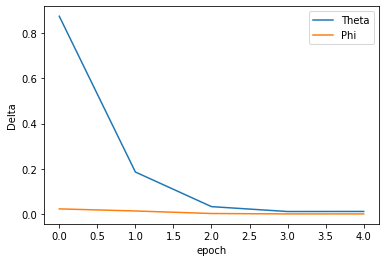

In [13]:
# 修改alpha 和 beta的值
# alpha 和 beta可以单独修改，而 K 需要重置其他参数
alpha = [1]*K;           # K，p(zk|dm) 所服从分布 Dir(alpha) 的超参数
beta = [1]*len(voc_list);   # V，p(wj|zk) 所服从分布 Dir(beta) 的超参数
epoch_n = 5;
package = [M,N,K,V,z,p,theta,phi,idx,alpha,beta,nd,nd_s,nw,nw_s];
history = estimate(epoch_n,copy.deepcopy(package),False);
show_delta(history);